In [3]:
import numpy as np
import pymc as pm

arms = [[0, 0], [0, 1], [1, 0], [1, 1]]


class MCMC_GLMTSAgent:
    def __init__(self) -> None:
        self.counts = [0 for _ in range(4)]
        self.wins = [0 for _ in range(4)]
        # 特徴量ベクトル([x1, x2, 1])を作成
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T

    def get_arm(self) -> int:
        if 0 in self.counts:
            return self.counts.index(0)

        with pm.Model() as model:
            weights = pm.Normal("w", mu=0, sigma=10, shape=3)
            # 線形予測子を計算
            linear_predictors = pm.math.dot(weights, self.phis)
            # link関数の逆関数(ロジスティック関数)を適用してthetaを計算
            thetas = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-linear_predictors)))

            obs = pm.Binomial("obs", p=thetas, n=self.counts, observed=self.wins)
            trace = pm.sample(2000, chains=1)

        # 各アームの報酬期待値 theta の事後分布からサンプリング
        sampled_thetas = pm.sample_posterior_predictive(trace, sample_dims=1, model=model, var_names=["theta"])
        return int(np.argmax(sampled_thetas["theta"]))

    def sample(self, arm_idx: int, reward: int) -> None:
        self.counts[arm_idx] += 1
        self.wins[arm_idx] += reward


In [4]:
class Env:
    def p(self, arm: list[int]) -> int:
        """各腕の真の報酬期待値が theta_k = logistic(0.2 * x1 + 0.8 * x2 - 4) で与えられるとする。"""
        x = arm[0] * 0.2 + arm[1] * 0.8 - 4
        return 1 / (1 + np.exp(-x))

    def react(self, arm: list[int]) -> int:
        """選ばれた腕に対して、報酬を返す"""
        return 1 if np.random.random() < self.p(arm) else 0

    def best_arm(self) -> int:
        """最も報酬期待値が大きい腕のインデックスを返す"""
        return int(np.argmax([self.p(arm) for arm in arms]))

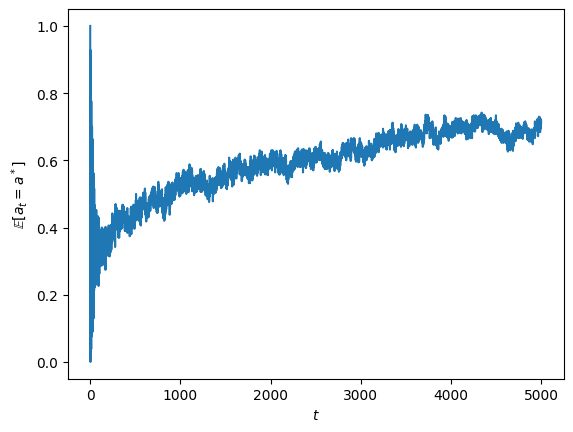

In [ ]:
from matplotlib import pyplot as plt


class LinUCBAgent:
    def __init__(self) -> None:
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        self.alpha = 1
        self.sigma = 1  # 観測される報酬rのばらつき(固定値と仮定)
        # 以下はパラメータwを算出するのに逐次的に更新するA, bの初期値
        self.A = np.identity(self.phis.shape[0])
        self.b = np.zeros((self.phis.shape[0], 1))

    def get_arms(self) -> int:
        inv_A = np.linalg.inv(self.A)
        post_theta_mean = inv_A.dot(self.b)
        post_theta_var = inv_A
        pred_mean = self.phis.T.dot(post_theta_mean)
        pred_var = self.phis.T.dot(post_theta_var).dot(self.phis)
        ucb_score = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
        return int(np.argmax(ucb_score))

    def sample(self, arm_idx: int, reward: int) -> None:
        phi = self.phis[:, [arm_idx]]
        # 更新式
        self.b = self.b + phi * reward / (self.sigma**2)
        self.A = self.A + phi.dot(phi.T) / (self.sigma**2)


n_iter = 500
n_step = 5000
selected_arms = np.zeros((n_iter, n_step), dtype=int)
observed_rewards = np.zeros((n_iter, n_step), dtype=int)
environment = Env()
for i in range(n_iter):
    agent = LinUCBAgent()
    for step in range(n_step):
        arm_idx = agent.get_arms()
        reward = environment.react(arms[arm_idx])
        agent.sample(arm_idx, reward)
        selected_arms[i, step] = arm_idx
        observed_rewards[i, step] = reward

plt.plot(np.mean(selected_arms == environment.best_arm(), axis=0))
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.show()


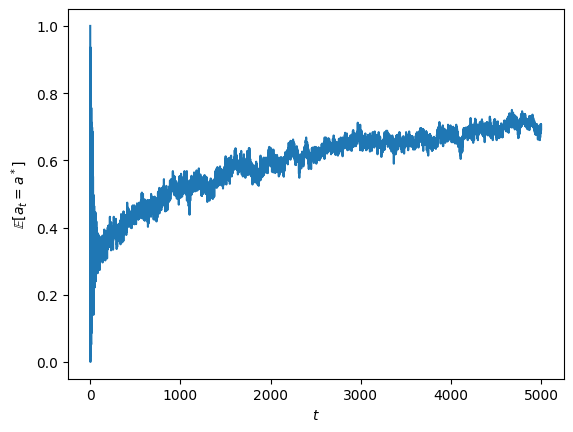

In [7]:
class LinUCBAgent2:
    def __init__(self) -> None:
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        self.alpha = 1
        self.sigma = 1  # 観測される報酬rのばらつき(固定値と仮定)
        self.inv_A = np.identity(self.phis.shape[0])
        self.b = np.zeros((self.phis.shape[0], 1))

    def get_arms(self) -> int:
        post_mean = self.inv_A.dot(self.b)
        post_var = self.inv_A
        pred_mean = self.phis.T.dot(post_mean)
        pred_var = self.phis.T.dot(post_var).dot(self.phis)
        ucb_score = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
        return int(np.argmax(ucb_score))

    def sample(self, arm_idx: int, reward: int) -> None:
        phi = self.phis[:, [arm_idx]]
        # 更新式
        iAppTiA = self.inv_A.dot(phi).dot(phi.T).dot(self.inv_A)
        s2_pTiAp = self.sigma**2 + phi.T.dot(self.inv_A).dot(phi)
        self.inv_A = self.inv_A - iAppTiA / s2_pTiAp
        self.b = self.b + (self.sigma**2) * phi * reward


n_iter = 500
n_step = 5000
selected_arms = np.zeros((n_iter, n_step), dtype=int)
observed_rewards = np.zeros((n_iter, n_step), dtype=int)
environment = Env()
for i in range(n_iter):
    agent = LinUCBAgent2()
    for step in range(n_step):
        arm_idx = agent.get_arms()
        reward = environment.react(arms[arm_idx])
        agent.sample(arm_idx, reward)
        selected_arms[i, step] = arm_idx
        observed_rewards[i, step] = reward

plt.plot(np.mean(selected_arms == environment.best_arm(), axis=0))
plt.xlabel(r"$t$")
plt.ylabel(r"$\mathbb{E}[a_t = a^*]$")
plt.show()
